
# MLB Strikeout Predictor

This notebook fetches data **online** using `pybaseball`
- Pulls **Statcast** pitch-level data for a chosen season and reconstructs **per-game pitcher logs**.
- Builds **opponent team profiles** with `team_batting` (e.g., K% via SO/PA).
- Engineers **rolling-form** features for pitchers (last *N* games).
- Trains a **RandomForestRegressor** to predict **per-game strikeouts (SO)**.
- Saves artifacts and plots feature importances.




## 1) Setup


In [33]:

# %pip install pybaseball pandas numpy scikit-learn matplotlib joblib tqdm
import warnings, os, math, datetime as dt
from pathlib import Path
warnings.filterwarnings('ignore')

DATA_DIR = Path('data'); DATA_DIR.mkdir(exist_ok=True)
ARTI_DIR = Path('artifacts'); ARTI_DIR.mkdir(exist_ok=True)

print('Online-only run. No local CSVs needed.')


Online-only run. No local CSVs needed.
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.



## 2) Imports & Parameters


In [34]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pybaseball import team_batting, statcast, playerid_reverse_lookup

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
SEASON = 2025
ROLL_WINDOW = 5           # rolling games for pitcher's recent form
DATE_CHUNK_DAYS = 7 
START_DATE = f"{SEASON}-03-01"
END_DATE   = f"{SEASON}-11-30"
random_state = 42
np.random.seed(random_state)

print(f"Season: {SEASON} | Chunk: {DATE_CHUNK_DAYS} days | Rolling: {ROLL_WINDOW}")


Season: 2025 | Chunk: 7 days | Rolling: 5



## 3) Fetch Data (Statcast chunks + team batting)
We fetch all pitches in the season via `statcast(start, end)` in weekly chunks.  
Then we **reconstruct pitcher per-game logs** (SO, PA, opponent team, date).


In [35]:

def daterange_chunks(start, end, step_days=7):
    start = pd.to_datetime(start).date()
    end = pd.to_datetime(end).date()
    cur = start
    step = pd.Timedelta(days=step_days)
    while cur <= end:
        nxt = min(cur + step - pd.Timedelta(days=1), end)
        yield str(cur), str(nxt)
        cur = nxt + pd.Timedelta(days=1)

def fetch_statcast_season(start, end, step_days=7):
    frames = []
    for s, e in tqdm(list(daterange_chunks(start, end, step_days)), desc="Downloading Statcast"):
        try:
            df = statcast(s, e)
            if df is not None and len(df):
                frames.append(df)
        except Exception as ex:
            print(f"Chunk {s} to {e} failed:", ex)
    if frames:
        out = pd.concat(frames, ignore_index=True)
        return out
    return pd.DataFrame()

print("Fetching team batting...")
tb = team_batting(SEASON)  # opponent profile source

print("Fetching Statcast (this can take a while)...")
sc = fetch_statcast_season(START_DATE, END_DATE, DATE_CHUNK_DAYS)
print("Statcast rows:", len(sc))


Fetching team batting...
Fetching Statcast (this can take a while)...


This is a large query, it may take a moment to complete
Skipping offseason dates



0it [00:00, ?it/s]

This is a large query, it may take a moment to complete


Skipping offseason dates



0it [00:00, ?it/s]

This is a large query, it may take a moment to complete




100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.51s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:11<00:00,  1.63s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.54s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.54s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.51s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:12<00:00,  1.74s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.45s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.48s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:11<00:00,  1.67s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.45s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:09<00:00,  1.40s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.51s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:10<00:00,  1.56s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:11<00:00,  1.66s/it]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 31.19it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 30.77it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 19.37it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 31.48it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 31.96it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00,  8.78it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 31.69it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 31.86it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 30.46it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 19.29it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 31.56it/s]

This is a large query, it may take a moment to complete



100%|██████████| 7/7 [00:00<00:00, 32.01it/s]

This is a large query, it may take a moment to complete
Skipping offseason dates



100%|██████████| 1/1 [00:00<00:00, 13.36it/s]

This is a large query, it may take a moment to complete


Skipping offseason dates



0it [00:00, ?it/s]

This is a large query, it may take a moment to complete


Skipping offseason dates



0it [00:00, ?it/s]


Statcast rows: 600204



## 4) Build Per-Game Pitcher Logs
- **SO per game**: count plate-appearances ending in strikeouts.
- **PA per game**: count unique `at_bat_number` (per pitcher-game).
- **Opponent team**: use the batting team per pitch:
  - When `inning_topbot == "Top"`, the **away** team is batting.
  - When `inning_topbot == "Bot"`, the **home** team is batting.
  The opponent for a pitcher is the **mode** of the batting team across their pitches in that game.


In [36]:

if sc.empty:
    raise RuntimeError("Statcast returned no data.")

# Normalize basics
sc['game_date'] = pd.to_datetime(sc['game_date']).dt.date
# batting team per pitch
sc['batting_team'] = np.where(sc['inning_topbot'].eq('Top'), sc['away_team'], sc['home_team'])

# SO events list (statcast 'events' field marks the outcome of PA on the terminal pitch)
SO_EVENTS = {'strikeout', 'strikeout_double_play'}

# Aggregate per pitcher-game
group_cols = ['pitcher', 'game_pk']
agg_rows = []
for (pid, gpk), g in tqdm(sc.groupby(group_cols), total=sc[group_cols].drop_duplicates().shape[0], desc="Aggregating pitcher-games"):
    so = (g['events'].isin(SO_EVENTS)).sum()
    pa = g['at_bat_number'].nunique()
    date = g['game_date'].iloc[0]
    home = g['home_team'].iloc[0]
    away = g['away_team'].iloc[0]
    # opponent team = mode of batting_team in this pitcher's pitches
    opp = g['batting_team'].mode().iloc[0] if len(g['batting_team']) else np.nan
    agg_rows.append((pid, gpk, date, home, away, opp, so, pa))

pgl = pd.DataFrame(agg_rows, columns=['pitcher_id','game_pk','game_date','home_team','away_team','opp_team','SO','PA'])
pgl = pgl.sort_values(['pitcher_id','game_date']).reset_index(drop=True)
print("Pitcher-game logs:", pgl.shape)
pgl.head(3)


Aggregating pitcher-games: 100%|██████████| 17887/17887 [00:25<00:00, 689.59it/s]


Pitcher-game logs: (17887, 8)


,pitcher_id,game_pk,game_date,home_team,away_team,opp_team,SO,PA
0,434378,778843,2025-03-17,CWS,SF,CWS,6,20
1,434378,778976,2025-03-22,SF,AZ,AZ,4,24
2,434378,778540,2025-03-29,CIN,SF,CIN,5,22



## 5) Add Pitcher Names


In [37]:

# Map pitcher_id -> name for readability (optional)
unique_pids = pgl['pitcher_id'].unique().tolist()
try:
    names = playerid_reverse_lookup(unique_pids, key_type='mlbam')
    name_map = dict(zip(names['key_mlbam'], names['name_first'] + ' ' + names['name_last']))
    pgl['pitcher_name'] = pgl['pitcher_id'].map(name_map)
except Exception as e:
    print("Name lookup failed, continuing without names:", e)
    pgl['pitcher_name'] = pgl['pitcher_id'].astype(str)

pgl.head(3)


,pitcher_id,game_pk,game_date,home_team,away_team,opp_team,SO,PA,pitcher_name
0,434378,778843,2025-03-17,CWS,SF,CWS,6,20,justin verlander
1,434378,778976,2025-03-22,SF,AZ,AZ,4,24,justin verlander
2,434378,778540,2025-03-29,CIN,SF,CIN,5,22,justin verlander



## 6) Build Opponent Team Profile
We compute **team K%** = SO/PA from `team_batting` and merge it to games via `opp_team`.


In [38]:

tb_cols = [c.strip() for c in tb.columns]
tb.columns = tb_cols

# Try to compute K% if not present
if 'SO' in tb.columns and 'PA' in tb.columns and 'K%' not in tb.columns and 'K_pct' not in tb.columns:
    tb['K_pct'] = 100 * (tb['SO'] / tb['PA'])

# Find team key
team_key = None
for k in ['Team','Tm','team']:
    if k in tb.columns:
        team_key = k; break
if team_key is None:
    raise ValueError("Could not find team column in team_batting.")

opp_profile = tb[[team_key, 'PA', 'SO'] + [c for c in ['K%', 'K_pct'] if c in tb.columns]].copy()
opp_profile = opp_profile.rename(columns={team_key:'TEAM'}).drop_duplicates('TEAM')
# Normalize a single K_pct column
if 'K%' in opp_profile.columns and 'K_pct' not in opp_profile.columns:
    opp_profile['K_pct'] = opp_profile['K%']
opp_profile = opp_profile[['TEAM','PA','SO','K_pct']].copy()

# Merge onto games
games = pgl.merge(opp_profile, left_on='opp_team', right_on='TEAM', how='left', suffixes=('', '_opp'))
print("Merged games with opponent profile:", games.shape)
games.head(3)


Merged games with opponent profile: (17887, 13)


,pitcher_id,game_pk,game_date,home_team,away_team,opp_team,SO,PA,pitcher_name,TEAM,PA_opp,SO_opp,K_pct
0,434378,778843,2025-03-17,CWS,SF,CWS,6,20,justin verlander,NaN,NaN,NaN,NaN
1,434378,778976,2025-03-22,SF,AZ,AZ,4,24,justin verlander,NaN,NaN,NaN,NaN
2,434378,778540,2025-03-29,CIN,SF,CIN,5,22,justin verlander,CIN,4780.0,1096.0,0.229



## 7) Rolling Form Features
Compute rolling **SO**, **K per PA** for each pitcher (last `ROLL_WINDOW` games).


In [39]:

def safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

games = games.sort_values(['pitcher_id','game_date']).reset_index(drop=True)
games['K_per_PA'] = safe_div(games['SO'], games['PA'])

roll = (
    games.groupby('pitcher_id')[['SO','K_per_PA']]
    .rolling(ROLL_WINDOW, min_periods=1).mean()
    .reset_index(level=0, drop=True)
    .add_prefix(f'roll{ROLL_WINDOW}_')
)
games = pd.concat([games, roll], axis=1)

print(games[['pitcher_name','game_date','SO','PA','K_per_PA',f'roll{ROLL_WINDOW}_SO',f'roll{ROLL_WINDOW}_K_per_PA']].head(8))


       pitcher_name   game_date  SO  PA  K_per_PA  roll5_SO  roll5_K_per_PA
0  justin verlander  2025-03-17   6  20  0.300000      6.00        0.300000
1  justin verlander  2025-03-22   4  24  0.166667      5.00        0.233333
2  justin verlander  2025-03-29   5  22  0.227273      5.00        0.231313
3  justin verlander  2025-04-04   2  14  0.142857      4.25        0.209199
4  justin verlander  2025-04-09   9  26  0.346154      5.20        0.236590
5  justin verlander  2025-04-15   1  26  0.038462      4.20        0.184282
6  justin verlander  2025-04-20   6  22  0.272727      4.60        0.205495
7  justin verlander  2025-04-25   5  23  0.217391      4.60        0.203518



## 8) Modeling (Regression on per-game SO)
We use numeric features only and compare a **mean baseline** vs a **RandomForestRegressor**.


In [40]:
# ==== Leakage-safe modeling prep + time-based split + training ====
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

# 0) Ensure chronological order per pitcher
games = games.sort_values(['pitcher_id', 'game_date']).reset_index(drop=True)

# 1) Build per-game rate (used ONLY to compute past rolling; we won't use K_per_PA directly)
if 'K_per_PA' not in games.columns:
    games['K_per_PA'] = safe_div(games['SO'], games['PA'])

# 2) Ensure rolling features use ONLY PAST games (no peeking)
ROLL_WINDOW = 5
if f'roll{ROLL_WINDOW}_SO' not in games.columns:
    games[f'roll{ROLL_WINDOW}_SO'] = (
        games.groupby('pitcher_id')['SO']
             .shift()
             .rolling(ROLL_WINDOW, min_periods=1)
             .mean()
    )
if f'roll{ROLL_WINDOW}_K_per_PA' not in games.columns:
    games[f'roll{ROLL_WINDOW}_K_per_PA'] = (
        games.groupby('pitcher_id')['K_per_PA']
             .shift()
             .rolling(ROLL_WINDOW, min_periods=1)
             .mean()
    )

# 3) Target
if 'SO' not in games.columns:
    raise ValueError("Target 'SO' not found in games dataframe.")
y = games['SO'].astype(float)

# 4) Numeric features
num = games.select_dtypes(include=[np.number]).copy()

# 5) Drop leakage & ID columns
leak_cols = {
    'SO',          # target
    'PA',          # same-game plate appearances -> directly tied to SO
    'K_per_PA',    # computed from SO/PA of current game
    'game_pk',     # identifier, helps memorize
    'pitcher_id'   # identifier, helps memorize
}
X = num.drop(columns=[c for c in leak_cols if c in num.columns], errors='ignore')

# 6) Impute remaining missing values
X = X.fillna(X.median(numeric_only=True))

# 7) Time-based split (first 80% of dates -> train, last 20% -> val)
unique_dates = np.array(sorted(games['game_date'].unique()))
cut_idx = max(1, int(0.8 * len(unique_dates)))  # ensure at least 1 date in train
cut_date = unique_dates[cut_idx - 1]

train_mask = games['game_date'] <= cut_date
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val,   y_val   = X.loc[~train_mask], y.loc[~train_mask]

# keep names for importances
feature_names = list(getattr(X_train, "columns", [f"feature_{i}" for i in range(X_train.shape[1])]))

print("Shapes -> X_train:", X_train.shape, " X_val:", X_val.shape)
print("Dropped (if present):", sorted(list(leak_cols & set(num.columns))) or "none")
print("Train date ≤", cut_date, "| Val date >", cut_date)

# 8) Baseline and model
baseline_pred = np.full_like(y_val, y_train.mean(), dtype=float)
baseline_mae = mean_absolute_error(y_val, baseline_pred)

rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)
rf.fit(X_train, y_train)
pred = rf.predict(X_val)
mae = mean_absolute_error(y_val, pred)
r2 = r2_score(y_val, pred)

print(f"Samples: train={len(y_train)} val={len(y_val)}")
print(f"Baseline MAE: {baseline_mae:.3f}")
print(f"RF MAE:       {mae:.3f}")
print(f"RF R^2:       {r2:.3f}")


Shapes -> X_train: (14303, 5)  X_val: (3584, 5)
Dropped (if present): ['K_per_PA', 'PA', 'SO', 'game_pk', 'pitcher_id']
Train date ≤ 2025-07-20 | Val date > 2025-07-20
Samples: train=14303 val=3584
Baseline MAE: 1.561
RF MAE:       0.949
RF R^2:       0.627



## 9) Feature Importances


,importance
roll5_SO,0.760686
roll5_K_per_PA,0.156130
PA_opp,0.033480
SO_opp,0.026357
K_pct,0.023347


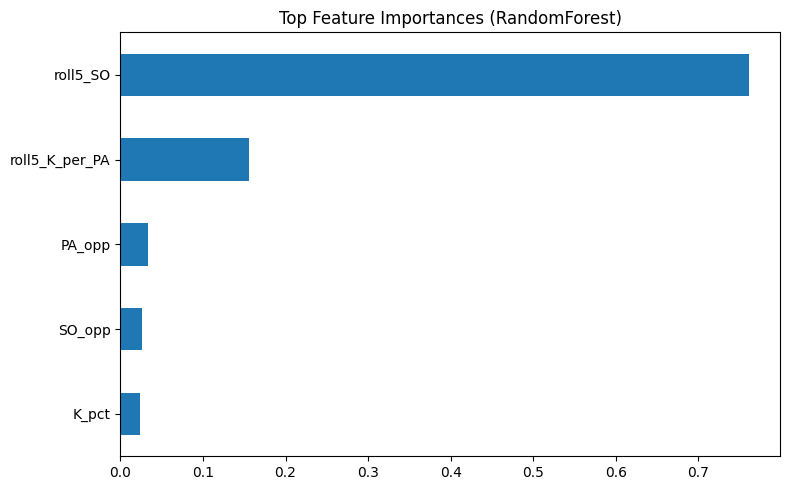

In [41]:
# feature importance plotting
import pandas as pd
import matplotlib.pyplot as plt

if hasattr(X_train, "columns"):
    feature_names = list(X_train.columns)
else:
    feature_names = [f"feature_{i}" for i in range(rf.n_features_in_)]

if len(feature_names) != len(rf.feature_importances_):
    print(f"[warn] mismatch: model has {len(rf.feature_importances_)} features, "
          f"but feature_names has {len(feature_names)}. Using generic names.")
    feature_names = [f"feature_{i}" for i in range(len(rf.feature_importances_))]

# Build series and plot
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

display(importances.head(20).to_frame("importance"))

plt.figure(figsize=(8,5))
importances.head(20)[::-1].plot(kind="barh")
plt.title("Top Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()



## 10) Predictions


In [43]:
# ==== Predict upcoming games (all teams) with probable pitchers ====
import pandas as pd
import numpy as np
import requests
from datetime import date, timedelta

# ---- Helper: schedule with probable pitchers from MLB Stats API
def fetch_probable_pitchers(start_date, end_date):
    """
    Returns a DataFrame with one row per (game, team) pitcher:
    columns: game_pk, game_date, team, opp_team, pitcher_id, pitcher_name, home_away
    """
    def daterange(d0, d1):
        cur = pd.to_datetime(d0).date()
        end = pd.to_datetime(d1).date()
        while cur <= end:
            yield cur
            cur += timedelta(days=1)

    rows = []
    for d in daterange(start_date, end_date):
        url = (
            "https://statsapi.mlb.com/api/v1/schedule"
            f"?sportId=1&date={d:%Y-%m-%d}&hydrate=probablePitcher(note,person)"
        )
        try:
            resp = requests.get(url, timeout=20)
            resp.raise_for_status()
            data = resp.json()
        except Exception as e:
            print(f"[warn] schedule fetch failed for {d}: {e}")
            continue

        for date_block in data.get("dates", []):
            for g in date_block.get("games", []):
                game_pk = g.get("gamePk")
                game_date = pd.to_datetime(g.get("gameDate")).date() if g.get("gameDate") else d

                away = g.get("teams", {}).get("away", {})
                home = g.get("teams", {}).get("home", {})
                away_team = away.get("team", {}).get("abbreviation")
                home_team = home.get("team", {}).get("abbreviation")

                for side, team_abbr, opp_abbr in [
                    ("away", away_team, home_team),
                    ("home", home_team, away_team),
                ]:
                    team_blob = g.get("teams", {}).get(side, {})
                    pp = team_blob.get("probablePitcher") or {}
                    pid = pp.get("id")
                    pname = pp.get("fullName")
                    if pid is None:
                        continue  # skip if no probable pitcher yet
                    rows.append(
                        {
                            "game_pk": game_pk,
                            "game_date": game_date,
                            "team": team_abbr,
                            "opp_team": opp_abbr,
                            "home_away": side,
                            "pitcher_id": pid,
                            "pitcher_name": pname,
                        }
                    )

    return pd.DataFrame(rows).drop_duplicates(subset=["game_pk", "team", "pitcher_id"])


# ---- Build feature row for a pitcher
def build_feature_row_for_pitcher(pid, opp_team, as_of_date, feature_names, games, X_train, team_daily=None):
    """
    Create a feature vector for a pitcher vs opp_team using latest past-only row from `games`,
    plus opponent context. Returns a Series indexed by feature_names.
    """
    past = games[(games["pitcher_id"] == pid) & (games["game_date"] < as_of_date)]
    if past.empty:
        return None

    last = past.sort_values("game_date").iloc[-1]
    feat = pd.Series(index=feature_names, dtype=float)

    for c in feature_names:
        if c in last.index:
            feat[c] = last[c]

    if team_daily is not None and "opp_team" in games.columns:
        td = team_daily[(team_daily["opp_team"] == opp_team) & (team_daily["game_date"] < as_of_date)].sort_values("game_date")
        if not td.empty:
            for col in ["opp_roll14_K_pct", "opp_roll30_K_pct"]:
                if col in feature_names and col in td.columns:
                    feat[col] = td.iloc[-1][col]

    for opp_col in ["K_pct", "SO_opp", "PA_opp"]:
        if opp_col in feature_names and opp_col in last.index and pd.notna(last[opp_col]):
            feat[opp_col] = last[opp_col]

    return feat.fillna(X_train.median(numeric_only=True))


# ---- Master function
def predict_upcoming(start_date=None, end_date=None):
    if start_date is None:
        start_date = date.today()
    if end_date is None:
        end_date = start_date

    sched = fetch_probable_pitchers(start_date, end_date)
    if sched.empty:
        print("No probable pitchers found in that window.")
        return pd.DataFrame()

    rows, missing = [], 0
    for _, row in sched.iterrows():
        pid, opp, gdate = int(row["pitcher_id"]), row["opp_team"], row["game_date"]

        feat = build_feature_row_for_pitcher(
            pid=pid,
            opp_team=opp,
            as_of_date=gdate,
            feature_names=feature_names,
            games=games,
            X_train=X_train,
            team_daily=globals().get("team_daily", None),
        )
        if feat is None:
            missing += 1
            continue

        pred_so = float(rf.predict([feat.values])[0])
        rows.append(
            {
                "Date": gdate,
                "Pitcher": row.get("pitcher_name"),
                "Team": row["team"],
                "Opponent": opp,
                "Predicted Ks": pred_so,
                "Home/Away": row.get("home_away"),
            }
        )

    out = pd.DataFrame(rows).sort_values(["Date", "Team"]).reset_index(drop=True)
    if not out.empty:
        out["Predicted Ks"] = out["Predicted Ks"].map("{:.1f}".format)
    if missing:
        print(f"Skipped {missing} pitcher(s) with no history.")
    return out


# ---- Example usage
preds = predict_upcoming(start_date=date.today(), end_date=date.today() + timedelta(days=2))
display(preds)



Skipped 1 pitcher(s) with no history.


,Date,Pitcher,Team,Opponent,Predicted Ks,Home/Away
0,2025-08-21,Jack Perkins,None,None,5.4,away
1,2025-08-21,José Ureña,None,None,1.7,home
2,2025-08-21,Patrick Corbin,None,None,3.0,away
3,2025-08-21,Michael Lorenzen,None,None,5.0,home
4,2025-08-21,Quinn Priester,None,None,3.9,away
5,2025-08-21,Shota Imanaga,None,None,6.2,home
6,2025-08-21,Clayton Kershaw,None,None,2.6,away
7,2025-08-21,Chase Dollander,None,None,3.6,home
8,2025-08-21,Sean Manaea,None,None,5.1,away
9,2025-08-21,MacKenzie Gore,None,None,3.3,home
